# Модуль А. Анализ и предобработка данных

## Импорт библиотек

In [15]:
# для преобразований фотографий
import cv2
from PIL import Image

# для работы с файловой системой
import os
import shutil

# модуль с более удобными словарями
from collections import defaultdict

# для разбиения на выборки
from sklearn.model_selection import train_test_split

# для визуализации
import matplotlib.pyplot as plt

# для работы с архивами
from zipfile import ZipFile

# для отслеживания времени
import time

# для прогресс баров
from tqdm import tqdm

# для вычисления хэша 
import hashlib

In [2]:
# получаем корневой путь
main_dir = os.getcwd()[:-8]
print("Текущая корневая директория:", main_dir)

Текущая корневая директория: d:\Helper\MLBazyak\chemp\face_recognitionV2


## Загрузка данных

в качестве данных, я получил архив с названием `Датасеты25.zip`. для начала работы, нужно их разархивировать.

Используя утилиту `WinRAR` я разархивировал папку `Датасеты25` в директорию `Data\`, а также переименовал папку на `Data25`, так как с русскими путями часто бывают проблемы. Папку для `MacOS` я решил не использовать

In [3]:
# путь к основной папке с данными
data_path = os.path.join(main_dir, r'Data\Data25')
# список всех представленных папок (датасетов)
datas_list = os.listdir(data_path)
# логирование
print(f'Папка с данными: {data_path}')
print(f'Всего предлагаемых датасетов: {len(datas_list)}')
print(f'Представленные папки: {datas_list}')

Папка с данными: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25
Всего предлагаемых датасетов: 3
Представленные папки: ['archive', 'archive-3', 'faces']


## Датасет 1: archive

### Структура данных в наборе


    -> archive\     # главная папка
        -> Extracted Faces\Extracted Faces\     # папка с кропнутыми лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография
                -> 1.jpg        # фотография
                
            -> 1\      
                -> 0.jpg
                -> 1.jpg

        -> Face Data\Face Dataset\      # папка с цельными лицами
            -> 0\       # "именная" папка
                -> 0.jpg        # фотография      
                -> 1.jpg        # фотография      

            -> 1\
                -> 0.jpg
                -> 1.jpg

In [22]:
# получаем путь к первому датасету (archive)
path_to_data1 = os.path.join(data_path, datas_list[0])
# логирование
print(f'Путь к первому датасету: {path_to_data1}')

Путь к первому датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive


В датасете представлены `2` основные папки - просто с фотографиями с лицами, и с кропами лиц тех же самых фотографий 

In [7]:
print(os.listdir(path_to_data1)) # 2 основные папки, и файл с логами
# получааем путь к папке с кропами
extracted_face_data1 = os.path.join(path_to_data1, r'Extracted Faces\Extracted Faces')
print(f'Путь к папке с кропами: {extracted_face_data1}')
# получаем путь к папке с целыми фото
face_data1 = os.path.join(path_to_data1, r'Face Data\Face Dataset')
print(f'Путь к папке с целыми фото: {face_data1}')

['Extracted Faces', 'Face Data']
Путь к папке с кропами: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Extracted Faces\Extracted Faces
Путь к папке с целыми фото: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive\Face Data\Face Dataset


### Анализ датасета, баланс классов, проверка пропусков

Датасет с кропами: всего 1324 папок


Датасет с кропами: сбор данных..: 100%|██████████| 1324/1324 [00:00<00:00, 13244.84folder/s]

Датасет с кропами: всего 6107 фотографий


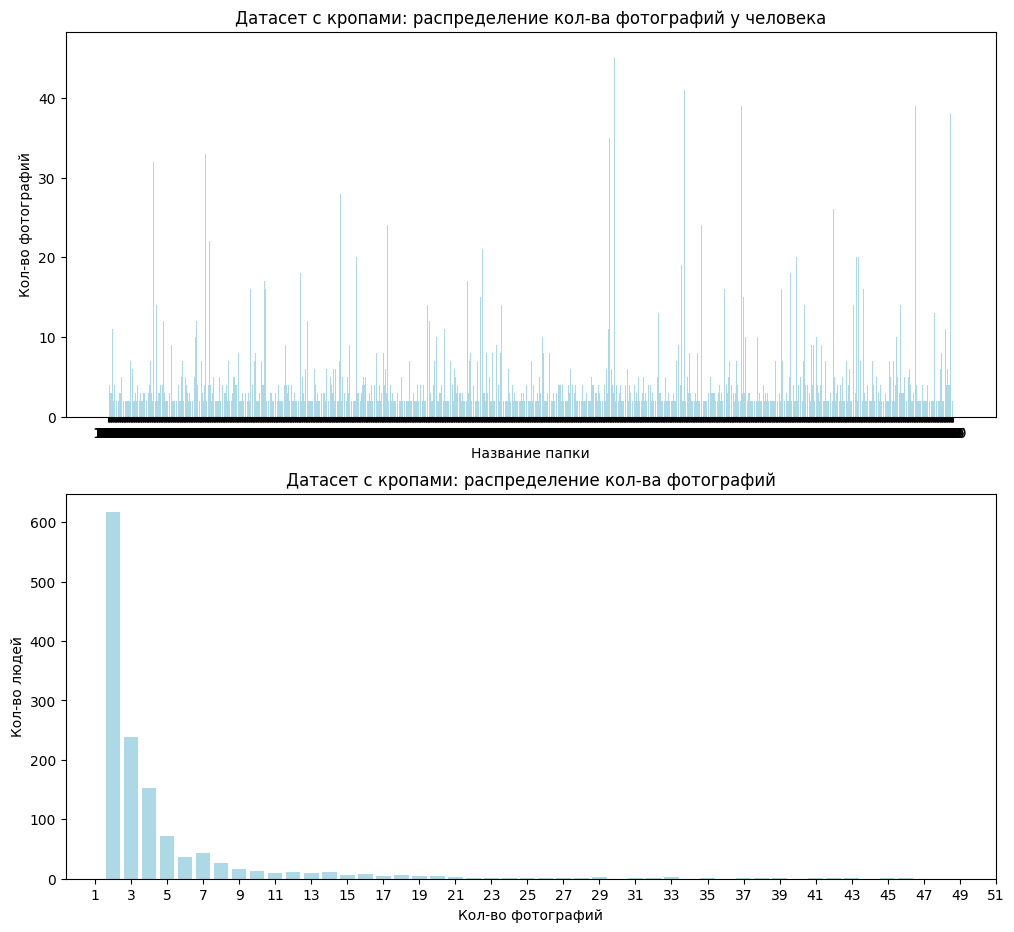

Максимальное кол-во: 46, номер папки - 1588
Топ 5 минимальных по заполненности значений у папки: [2, 3, 4, 5, 6]
-----------------------------------
Датасет с фотографиями: всего 1680 папок


Датасет с фотографиями: сбор данных..: 100%|██████████| 1680/1680 [00:00<00:00, 29676.80folder/s]

Датасет с фотографиями: всего 8204 фотографий


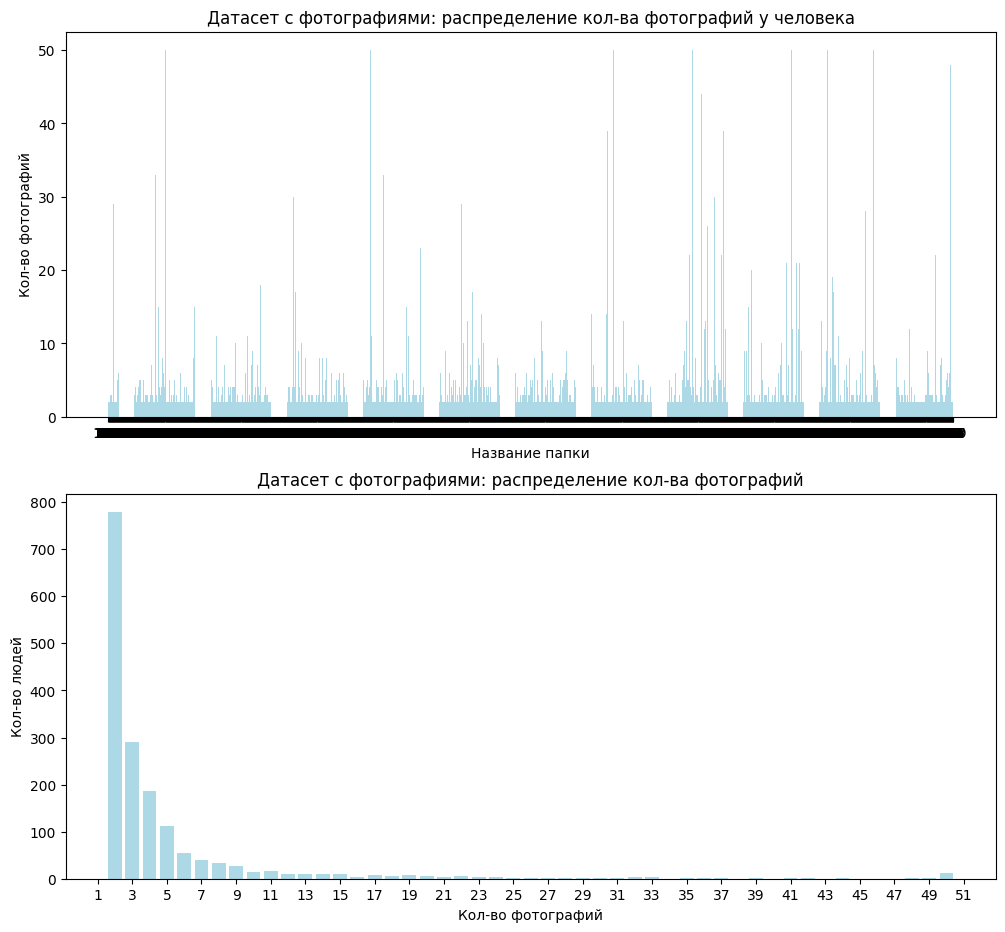

Максимальное кол-во: 50, номер папки - 110
Топ 5 минимальных по заполненности значений у папки: [2, 3, 4, 5, 6]
-----------------------------------


In [16]:
# список с именами датасетов
data_names = ['Датасет с кропами', 'Датасет с фотографиями']
datas = [extracted_face_data1, face_data1]

# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]
    # логирование
    print(f'{data_names[i]}: всего {len(os.listdir(datas[i]))} папок')
    # счетчик фотографий
    counter = 0
    # 
    max_name, max_value = 0,0
    # словарь для статистики
    nums_stats = defaultdict(int)
    value_stats = defaultdict(int)
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(data), desc=f'{data_names[i]}: сбор данных..', unit='folder'):
        # получаем путь к папке
        folder_path = os.path.join(datas[i], folder)
        # обновляем счетчик и вводим статистику в словарь
        img_nums = len(os.listdir(folder_path))
        #
        if img_nums > max_value:
            max_value=img_nums
            max_name=folder

        counter+=img_nums
        
        nums_stats[folder]=img_nums
        value_stats[img_nums]+=1

    print(f'{data_names[i]}: всего {counter} фотографий')

    # парсим получившийся словарь
    nums = nums_stats.values()
    folders = nums_stats.keys()

    fig, ax = plt.subplots(2,1,figsize=(12,11))
    # визуализируем результат
    ax[0].bar(folders, nums, color='lightblue')
    ax[0].set_title(f'{data_names[i]}: распределение кол-ва фотографий у человека')
    ax[0].set_xlabel('Название папки')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    value = value_stats.keys()
    # визуализируем результат
    ax[1].bar(value, counts, color='lightblue')
    ax[1].set_title(f'{data_names[i]}: распределение кол-ва фотографий')
    ax[1].set_xlabel('Кол-во фотографий')
    ax[1].set_ylabel('Кол-во людей')
    ax[1].set_xticks(range(1,52,2))
    plt.show()
    # логирование
    print(f'Максимальное кол-во: {max_value}, номер папки - {max_name}')
    print('Топ 5 минимальных по заполненности значений у папки:', list(set(list(value)))[0:5])
    print('-----------------------------------')



**По результатам анализа можно заметить что:**

- в каждой папке есть минимум 2 фотографии (нет пропусков в датасете)
- макс кол-во фотографий у датасета с кропами: `46`
- макс кол-во фотографий у датасета с целыми фотографиями: `50`
- у большинства людей из папок по 2 фотографии
- в датасете с кропами на `356` папок меньше, чем в полных фотографиях (от них надо избавиться)

### Проверка на формат фотографий в датасете

Датасет с кропами: анализ..: 100%|██████████| 1324/1324 [00:01<00:00, 1321.01folder/s]


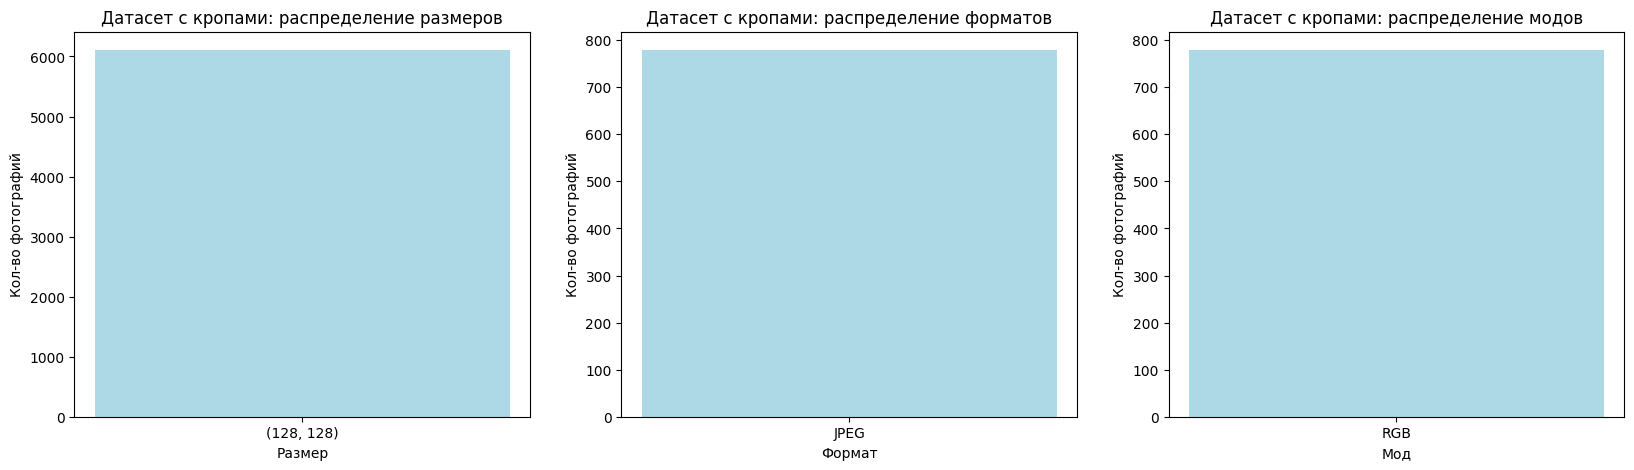

Датасет с фотографиями: анализ..: 100%|██████████| 1680/1680 [00:01<00:00, 1442.02folder/s]


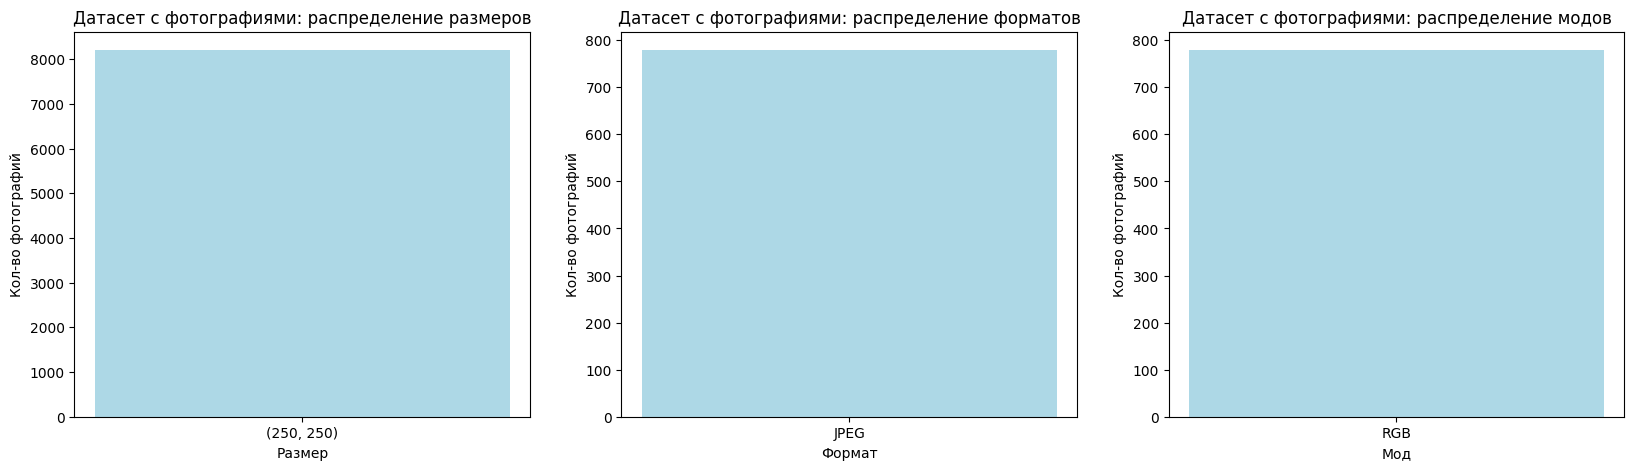

In [12]:
# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]

    # словари для статистики
    mode_stats = defaultdict(int)
    size_stats = defaultdict(int)
    format_stats = defaultdict(int)
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(datas[i]), desc=f'{data_names[i]}: анализ..', unit='folder'):
        # путь к папке
        folder_path = os.path.join(datas[i], folder)
        # проходимся по каждой фотографии в папке
        for img in os.listdir(folder_path):
            # путь к фотографии
            img_path = os.path.join(folder_path, img)
            # открываем фотографию испльзуя pillow
            img = Image.open(img_path)
            # обновляем словари
            size_stats[f'{img.size}']+=1
            format_stats[img.format]+=1
            mode_stats[img.mode]+=1

    # разбиваем график на несколько
    fig, ax = plt.subplots(1,3,figsize=(20,5))
    # парсим получившийся словарь
    counts = size_stats.values()
    size = size_stats.keys()
    # визуализируем результат
    ax[0].bar(size, counts, color='lightblue')
    ax[0].set_title(f'{data_names[i]}: распределение размеров')
    ax[0].set_xlabel('Размер')
    ax[0].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    format_ = format_stats.keys()
    # визуализируем результат
    ax[1].bar(format_, counts, color='lightblue')
    ax[1].set_title(f'{data_names[i]}: распределение форматов')
    ax[1].set_xlabel('Формат')
    ax[1].set_ylabel('Кол-во фотографий')

    # парсим получившийся словарь
    counts = value_stats.values()
    mode = mode_stats.keys()
    # визуализируем результат
    ax[2].bar(mode, counts, color='lightblue')
    ax[2].set_title(f'{data_names[i]}: распределение модов')
    ax[2].set_xlabel('Мод')
    ax[2].set_ylabel('Кол-во фотографий')

    plt.show()    

Можно заметить, что `размер`, `мод` и `формат` у всех изображений на каждой папке одинаковый, так что датасеты приведены к стандартизированному формату

### Проверка датасета на дубликаты

In [ ]:
# функция для вычисления хэша
def calculate_hash(image_path):
    '''Вычисляет хеш изображения.'''
    # открываем фотографию
    with open(image_path, "rb") as f:
        # извлекаем хэш
        return hashlib.md5(f.read()).hexdigest()

In [ ]:
# словарь с хэшами
hash_dict = {}
# список с дубликатами
duplicates = []

# проходимся по каждому датасету
for i in range(len(datas)):
    # получаем путь к датасету
    data = datas[i]
    # проходимся по каждой папке 
    for folder in tqdm(os.listdir(data), desc=f'{data_names[i]}: поиск дубликатов..', unit='folder'):
        # путь к папке
        folder_path = os.path.join(datas[i], folder)
        # проходимся по каждой фотографии в папке
        for img in os.listdir(folder_path):
            # путь к фотографии
            img_path = os.path.join(folder_path, img)
            # вычисляем хэш
            image_hash = calculate_hash(img_path)
            # првоеряем, есть ли такой хэш в словаре
            if image_hash in hash_dict:
                # если да, то обновляем список с дубликатами
                duplicates.append((img_path, hash_dict[image_hash]))
            # если нет, то добавляем хэш в словарь
            else:
                hash_dict[image_hash] = img_path
    # если дубликаты есть
    if duplicates:
        print(f'{data_names[i]}: найдены дубликаты')
        for dup in duplicates:
            print(f"Дубликат: {dup[0]} и {dup[1]}")
    # если дубликатов нет
    else:
        print(f'{data_names[i]}: дубликаты не найдены')
    # логирование
    print('Поиск дубликатов закончен')


Датасет с кропами: поиск дубликатов..: 100%|██████████| 1324/1324 [00:00<00:00, 2215.99folder/s]


Датасет с кропами: дубликаты не найдены
Поиск дубликатов закончен


Датасет с фотографиями: поиск дубликатов..: 100%|██████████| 1680/1680 [00:01<00:00, 1462.96folder/s]

Датасет с фотографиями: дубликаты не найдены
Поиск дубликатов закончен


**Дубликаты не были обнаружены**

## Датасет 2: archive-3

### Структура данных в наборе

In [76]:
# получаем путь ко второму датасету (archive-3)
path_to_data2 = os.path.join(data_path, datas_list[1])
# логирование
print(f'Путь ко второму датасету: {path_to_data2}')

Путь ко второму датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3



    -> archive-3\     # главная папка
        -> Faces\Faces\     # папка с кропнутыми лицами
            -> Akshay Kumar_0.jpg        # фотография
            -> Akshay Kumar_1.jpg        # фотография
            -> Akshay Kumar_2.jpg        # фотография
            -> Akshay Kumar_3.jpg        # фотография
            -> etc ...
        
        -> Original Images\     # папка с именными папками с цельными фото
            -> Akshay Kumar\     # именная папка 
                -> Akshay Kumar_0.jpg       # фотография
                -> Akshay Kumar_1.jpg       # фотография      
                -> Akshay Kumar_2.jpg       # фотография
                -> Akshay Kumar_3.jpg       # фотография    

            -> Alia Bhatt\
            -> Camila Cabello\
            -> etc ...

        -> Dataset.csv      # csv файл с названием файла и именем человека на фото



Выведем, что в папке `archive-3`

In [50]:
print(os.listdir(path_to_data2))

['Dataset.csv', 'Faces', 'Original Images']


In [51]:
# пути к папкам с кропами и к оригинальным фото
faces_path = os.path.join(path_to_data2, r'Faces\Faces')
orig_img_faces = os.path.join(path_to_data2, r'Original Images\Original Images')
# получим список файлов по этим путям
faces_data = os.listdir(faces_path)
orig_img_data = os.listdir(orig_img_faces)

### Анализ датасета, баланс классов, проверка пропусков

Папка с кропами лиц: 2562 фотографий
Папка с оригинальными фотографиями: 31 имен
Всего фотографий в оригинальных папках: 2562


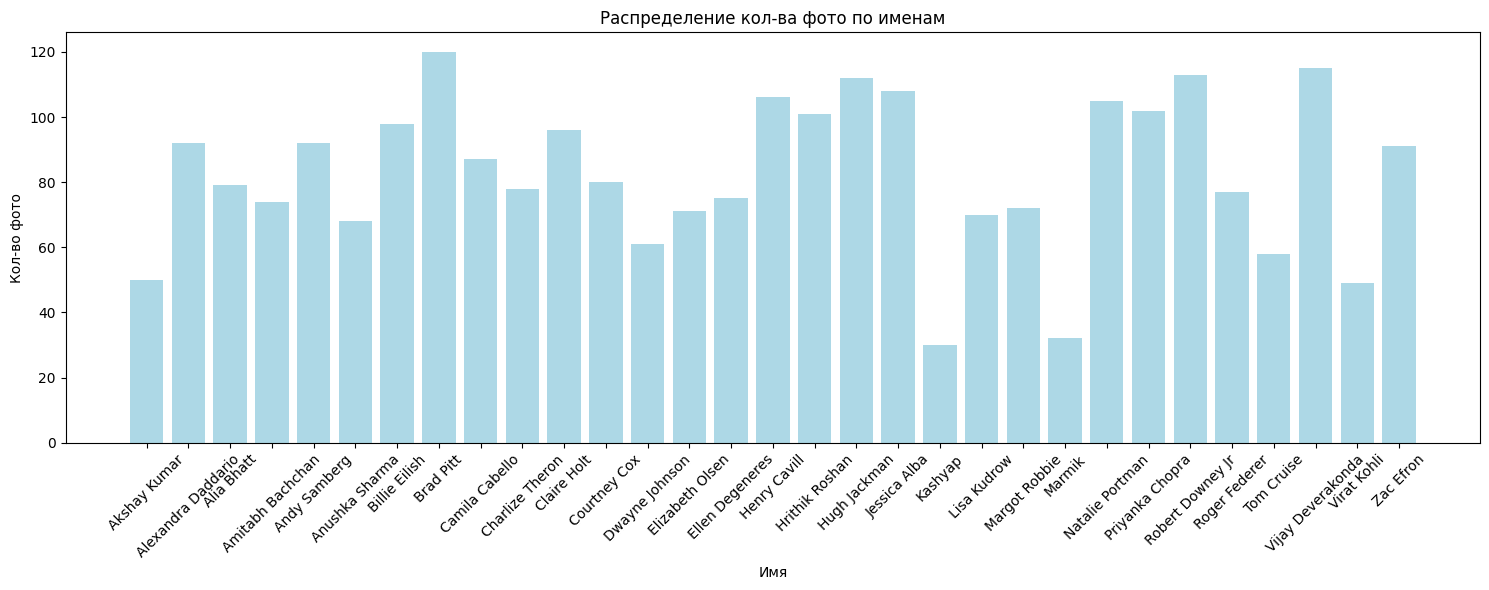

У Brad Pitt наибольшее кол-во фотографий - 120


In [52]:
# логирование
print('Папка с кропами лиц:',len(faces_data), 'фотографий')
print('Папка с оригинальными фотографиями:',len(orig_img_data), 'имен')
# счетчик
counter = 0
# макс кол-во фотографий
max_name, max_img = '', 0
# словарь для статистики
nums_stats = defaultdict(int)
# проходимся по каждой папке
for name in orig_img_data:
    # путь к имени
    name_path = os.path.join(orig_img_faces, name)
    # кол-во фотографий
    img_count = len(os.listdir(name_path))
    # обновляем счетчик
    counter+=img_count
    # обновляем словарь
    nums_stats[name] = img_count
    # ищем макс колво фотографий
    if img_count > max_img:
        max_img = img_count
        max_name = name

print(f'Всего фотографий в оригинальных папках: {counter}')
# парсим словарь
names = list(nums_stats.keys())
img_count = list(nums_stats.values())
# визуализация результатов
plt.figure(figsize=(15,6))
plt.bar(names, img_count, color='lightblue')
plt.xlabel('Имя')
plt.ylabel('Кол-во фото')
plt.xticks(names, rotation=45)
plt.title('Распределение кол-ва фото по именам')
plt.tight_layout()
plt.show()

# макс колво фото
print(f'У {max_name} наибольшее кол-во фотографий - {max_img}')

всего в датасете `31` человек, и `2562`

### Проверка дубликатов

**Датасет с кропами:**

In [ ]:
# словарь с хэшами
hash_dict = {}
# список с дубликатами
duplicates = []

# проходимся по каждой фотографии в папке
for img in tqdm(faces_data, desc=f'Датасет с кропами: поиск дубликатов..', unit='image'):
    # путь к фотографии
    img_path = os.path.join(faces_path, img)
    # вычисляем хэш
    image_hash = calculate_hash(img_path)
    # првоеряем, есть ли такой хэш в словаре
    if image_hash in hash_dict:
        # если да, то обновляем список с дубликатами
        duplicates.append((img_path, hash_dict[image_hash]))
    # если нет, то добавляем хэш в словарь
    else:
        hash_dict[image_hash] = img_path
        
# если дубликаты есть
if duplicates:
    print(f'Датасет с кропами: найдены дубликаты - {len(duplicates)} штук')
    for dup in duplicates:
        print(f"Дубликат: {dup[0]} и {dup[1]}")
        # удаляем найденные дубликаты
        os.remove(dup[0])
        os.remove(dup[1])

# если дубликатов нет
else:
    print(f'Датасет с кропами: дубликаты не найдены')
# логирование
print(f'Итоговое кол-во фото: {len(os.listdir(faces_path))}')
print('Поиск дубликатов закончен')


Датасет с кропами: поиск дубликатов..: 100%|██████████| 2562/2562 [00:29<00:00, 87.68image/s] 

Датасет с кропами: найдены дубликаты - 5 штук
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_45.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_23.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_9.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Courtney Cox_10.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Henry Cavill_5.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Henry Cavill_25.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Hugh Jackman_83.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Hugh Jackman_82.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Faces\Faces\Natalie Portman_93.jpg и d:\Helper\M

**Датасет с оригинальными фотографиями:**

In [ ]:
# словарь с хэшами
hash_dict = {}
# список с дубликатами
duplicates = []

# проходимся по каждой папке
for folder in tqdm(orig_img_data, desc=f'Датасет с оригиналами: поиск дубликатов..', unit='folder'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # вычисляем хэш
        image_hash = calculate_hash(img_path)
        # првоеряем, есть ли такой хэш в словаре
        if image_hash in hash_dict:
            # если да, то обновляем список с дубликатами
            duplicates.append((img_path, hash_dict[image_hash]))
        # если нет, то добавляем хэш в словарь
        else:
            hash_dict[image_hash] = img_path

# если дубликаты есть
if duplicates:
    print(f'Датасет с оригиналами: найдены дубликаты - {len(duplicates)} штук')
    for dup in duplicates:
        print(f"Дубликат: {dup[0]} и {dup[1]}")
        # удаляем найденные дубликаты
        os.remove(dup[0])
        os.remove(dup[1])

# если дубликатов нет
else:
    print(f'Датасет с оригиналами: дубликаты не найдены')
# логирование
print('Дубликаты удалены')
print('Поиск дубликатов закончен')


Датасет с оригиналами: поиск дубликатов..: 100%|██████████| 31/31 [00:01<00:00, 18.44folder/s]

Датасет с оригиналами: найдены дубликаты - 4 штук
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_45.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_23.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_9.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Courtney Cox\Courtney Cox_10.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Hugh Jackman\Hugh Jackman_83.jpg и d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Hugh Jackman\Hugh Jackman_82.jpg
Дубликат: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\archive-3\Original Images\Original Images\Natalie Portman\Natal

### Проверка на формат изображений в датасетах

**Датасет с кропами**

Датасет с кропами: анализ фото..: 100%|██████████| 2552/2552 [00:00<00:00, 6407.95images/s]


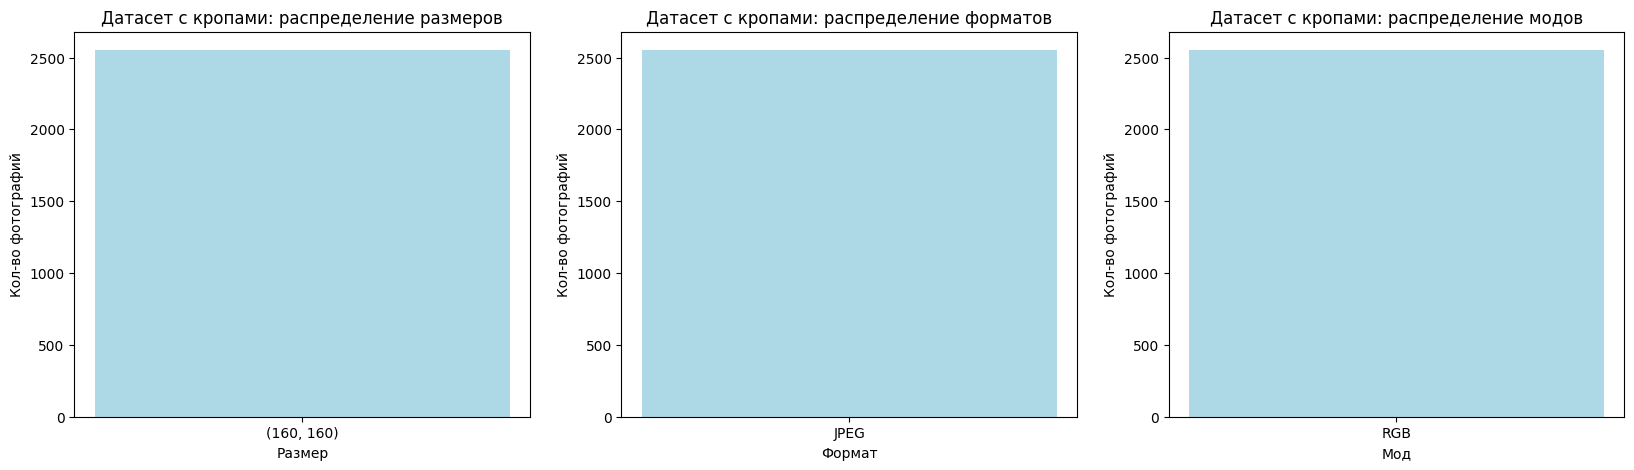

In [65]:
# словари для статистики
mode_stats = defaultdict(int)
size_stats = defaultdict(int)
format_stats = defaultdict(int)

# проходимся по каждой фотографии в папке
for img in tqdm(os.listdir(faces_path), desc='Датасет с кропами: анализ фото..', unit='images'):
    # путь к фотографии
    img_path = os.path.join(faces_path, img)
    # открываем фотографию испльзуя pillow
    img = Image.open(img_path)
    # обновляем словари
    size_stats[f'{img.size}']+=1
    format_stats[img.format]+=1
    mode_stats[img.mode]+=1

# разбиваем график на несколько
fig, ax = plt.subplots(1,3,figsize=(20,5))
# парсим получившийся словарь
counts = size_stats.values()
size = size_stats.keys()
# визуализируем результат
ax[0].bar(size, counts, color='lightblue')
ax[0].set_title(f'Датасет с кропами: распределение размеров')
ax[0].set_xlabel('Размер')
ax[0].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = format_stats.values()
format_ = format_stats.keys()
# визуализируем результат
ax[1].bar(format_, counts, color='lightblue')
ax[1].set_title(f'Датасет с кропами: распределение форматов')
ax[1].set_xlabel('Формат')
ax[1].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = mode_stats.values()
mode = mode_stats.keys()
# визуализируем результат
ax[2].bar(mode, counts, color='lightblue')
ax[2].set_title(f'Датасет с кропами: распределение модов')
ax[2].set_xlabel('Мод')
ax[2].set_ylabel('Кол-во фотографий')

plt.show()    

Все фотографии в датасете с кропами одного `размера`, `мода` и `формата`

**Датасет с оригинальными фотографиями:**

Датасет с оригиналами: анализ фото..: 100%|██████████| 31/31 [00:00<00:00, 64.16images/s]


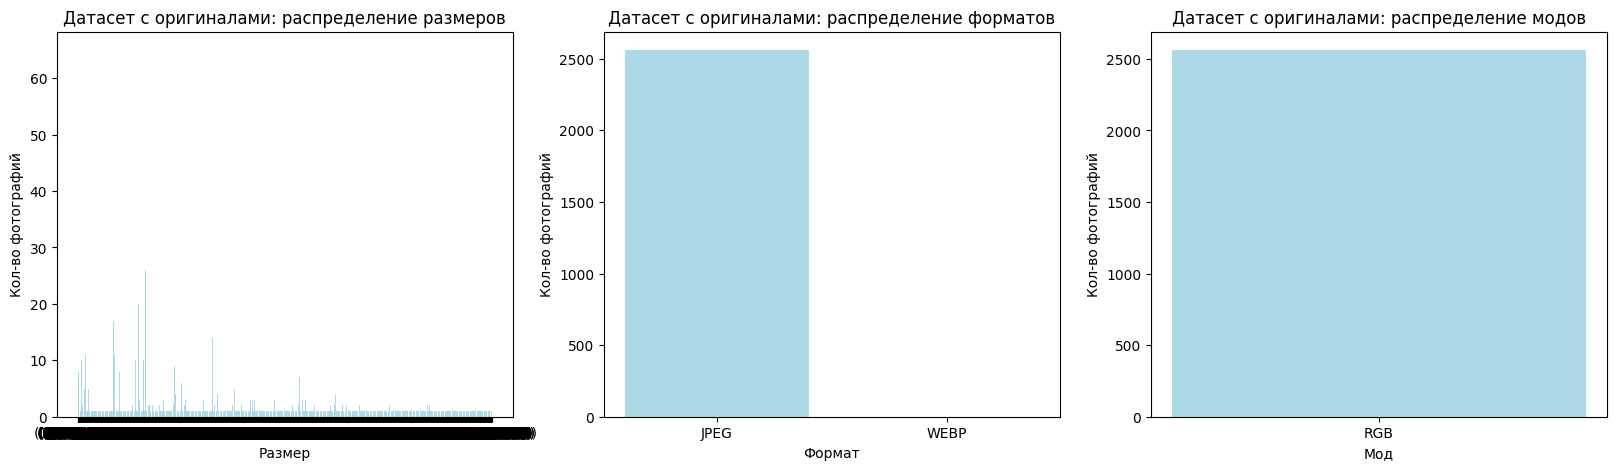

In [66]:

# словари для статистики
mode_stats = defaultdict(int)
size_stats = defaultdict(int)
format_stats = defaultdict(int)
# проходимся по каждой папке 
for folder in tqdm(os.listdir(orig_img_faces), desc='Датасет с оригиналами: анализ фото..', unit='images'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # обновляем словари
        size_stats[f'{img.size}']+=1
        format_stats[img.format]+=1
        mode_stats[img.mode]+=1

# разбиваем график на несколько
fig, ax = plt.subplots(1,3,figsize=(20,5))
# парсим получившийся словарь
counts = size_stats.values()
size = size_stats.keys()
# визуализируем результат
ax[0].bar(size, counts, color='lightblue')
ax[0].set_title(f'Датасет с оригиналами: распределение размеров')
ax[0].set_xlabel('Размер')
ax[0].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = format_stats.values()
format_ = format_stats.keys()
# визуализируем результат
ax[1].bar(format_, counts, color='lightblue')
ax[1].set_title(f'Датасет с оригиналами: распределение форматов')
ax[1].set_xlabel('Формат')
ax[1].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = mode_stats.values()
mode = mode_stats.keys()
# визуализируем результат
ax[2].bar(mode, counts, color='lightblue')
ax[2].set_title(f'Датасет с оригиналами: распределение модов')
ax[2].set_xlabel('Мод')
ax[2].set_ylabel('Кол-во фотографий')

plt.show()    

Все фотографии одного `мода`, но разного `размера` и несколько фотографий другого `формата`

In [73]:
# новый размер фотографий
new_size = (640,640)
# проходимся по каждой папке 
for folder in tqdm(os.listdir(orig_img_faces), desc='Датасет с оригиналами: преобразование фото..', unit='images'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # меняем размер фотографий
        img = img.resize(new_size, resample=Image.Resampling.LANCZOS)
        # новый путь
        new_path = img_path.split('.')[0]+'.jpg'
        # меняем формат фотографии и сохраняем
        img = img.save(new_path, format='JPEG')

Датасет с оригиналами: преобразование фото..: 100%|██████████| 31/31 [01:31<00:00,  2.94s/images]


После преобразований, проверим еще раз информацию по фотографиям:

Датасет с оригиналами: анализ фото..: 100%|██████████| 31/31 [00:26<00:00,  1.16folder/s]


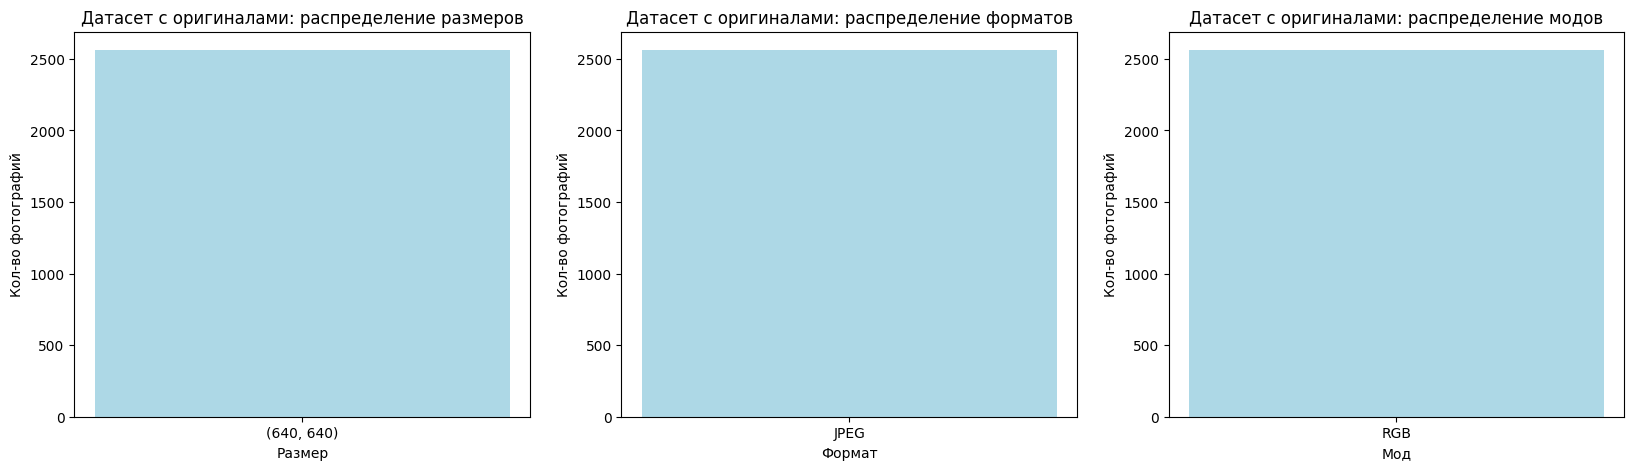

In [75]:

# словари для статистики
mode_stats = defaultdict(int)
size_stats = defaultdict(int)
format_stats = defaultdict(int)
# проходимся по каждой папке 
for folder in tqdm(os.listdir(orig_img_faces), desc='Датасет с оригиналами: анализ фото..', unit='folder'):
    # путь к папке
    folder_path = os.path.join(orig_img_faces, folder)
    # проходимся по каждой фотографии в папке
    for img in os.listdir(folder_path):
        # путь к фотографии
        img_path = os.path.join(folder_path, img)
        # открываем фотографию испльзуя pillow
        img = Image.open(img_path)
        # обновляем словари
        size_stats[f'{img.size}']+=1
        format_stats[img.format]+=1
        mode_stats[img.mode]+=1

# разбиваем график на несколько
fig, ax = plt.subplots(1,3,figsize=(20,5))
# парсим получившийся словарь
counts = size_stats.values()
size = size_stats.keys()
# визуализируем результат
ax[0].bar(size, counts, color='lightblue')
ax[0].set_title(f'Датасет с оригиналами: распределение размеров')
ax[0].set_xlabel('Размер')
ax[0].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = format_stats.values()
format_ = format_stats.keys()
# визуализируем результат
ax[1].bar(format_, counts, color='lightblue')
ax[1].set_title(f'Датасет с оригиналами: распределение форматов')
ax[1].set_xlabel('Формат')
ax[1].set_ylabel('Кол-во фотографий')

# парсим получившийся словарь
counts = mode_stats.values()
mode = mode_stats.keys()
# визуализируем результат
ax[2].bar(mode, counts, color='lightblue')
ax[2].set_title(f'Датасет с оригиналами: распределение модов')
ax[2].set_xlabel('Мод')
ax[2].set_ylabel('Кол-во фотографий')

plt.show()    

Теперь, все фотографии сохранены в одном `размере`, `формате` и `моде`

### Датасет 3: faces

### Структура данных в наборе

In [77]:
# получаем путь ко второму датасету (archive-3)
path_to_data3 = os.path.join(data_path, datas_list[2])
# логирование
print(f'Путь к третьему датасету: {path_to_data3}')

Путь к третьему датасету: d:\Helper\MLBazyak\chemp\face_recognitionV2\Data\Data25\faces


смотрим, что находится в этом датасете

In [79]:
print(os.listdir(path_to_data3))

['man', 'woman']


In [80]:
# получаем путь к папке с мужчинами, и с женщинами
mans_path = os.path.join(path_to_data3, 'man')
womans_path = os.path.join(path_to_data3, 'woman')
# получаем списки с набором данных
mans_data = os.listdir(mans_path)
womans_data = os.listdir(womans_path)
# проверка путей
print(f'Кол-во мужских фотографий: {len(mans_data)}')
print(f'Кол-во женских фотографий: {len(womans_data)}')


Кол-во мужских фотографий: 17678
Кол-во женских фотографий: 9489



    -> faces\     # главная папка
        -> man\     # папка с мужскими фотографиями лиц
            -> man_0.jpg        # фотография
            -> man_1.jpg        # фотография
            -> man_2.jpg        # фотография
            -> man_3.jpg        # фотография
            -> man_4.jpg        # фотография
            -> etc ...
        
        -> woman\     # папка с женскими фотографиями лиц
            -> woman_0.jpg        # фотография
            -> woman_1.jpg        # фотография
            -> woman_2.jpg        # фотография
            -> woman_3.jpg        # фотография
            -> woman_4.jpg        # фотография
            -> etc ...

